## Задача 4

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts

In [3]:
exam_df = pd.read_excel('exam_results.xls')
exam_df.drop(columns=['Номер', 'ИО'], inplace=True)
exam_df.columns = ['Surname', 'Score']
exam_df

,Surname,Score
0,Репенкова,16
1,Ролдугина,0
2,Сафина,19
3,Сидоров,26
4,Солоухин,21
...,...,...
327,Сенников,19
328,Ся,0
329,Сятова,0
330,Темиркулов,0


In [4]:
def first_letter(surname):
    if surname[0].lower() in vowels:
        return True
    return False

In [5]:
# Для начала разделим данные таблицы по фамилиям, начинающимся с гласной и согласной букв
vowels = {'а', 'е', 'ё', 'и', 'о', 'у', 'ы', 'э', 'ю', 'я'}

In [6]:
# Зададим уровень значимости
alpha = 0.05  

# Выделим выборки
vowels_cond = np.vectorize(first_letter)(exam_df['Surname'])
C = exam_df[~vowels_cond]
V = exam_df[vowels_cond]

__a)__ Воспользуемся тестом Уэлча

In [34]:
gamma_obs, p_value = sts.ttest_ind(C['Score'], V['Score'], equal_var=False)
# Укажем p_value
print(f"p-value = {p_value}")

# Заметим, что p-value больше, чем уровень значимости
p_value > alpha

p-value = 0.3974027153843839


True

__Вывод:__ Гипотеза о равенстве ожидаемых результатов экзамена по теории вероятностей тех, у кого фамилия начинается с гласной буквы и тех, у кого с согласной буквы, не отвергается.

__б)__ Используем наивный бутстрэп

In [37]:
C_base_sample = C['Score'].values
V_base_sample = V['Score'].values

In [38]:
# Создадим бутсрэп-выборки
np.random.seed(111)
C_bootstrapped = np.random.choice(C_base_sample, size=(10000, C_base_sample.shape[0]))
V_bootstrapped = np.random.choice(V_base_sample, size=(10000, V_base_sample.shape[0]))

In [39]:
def d_star(C_sample, V_sample):
    return np.mean(C_sample) - np.mean(V_sample)

In [40]:
d_stars = np.array([d_star(C_sample, V_sample) for C_sample, V_sample in zip(C_bootstrapped, V_bootstrapped)])

In [41]:
q_l = np.quantile(d_stars, q=alpha/2)
q_r = np.quantile(d_stars, q=1-alpha/2)
print(q_l, q_r)

-1.3842593928030582 3.5980961996105845


In [42]:
# Посчитаем наблюдаемое значение
d_hat = np.mean(C_base_sample) - np.mean(V_base_sample)
d_hat

1.0782433114588574

In [43]:
# Посчитаем p-value
p_value = 2 * min(np.mean(d_stars <= 0), np.mean(d_stars > 0))
p_value

0.3966

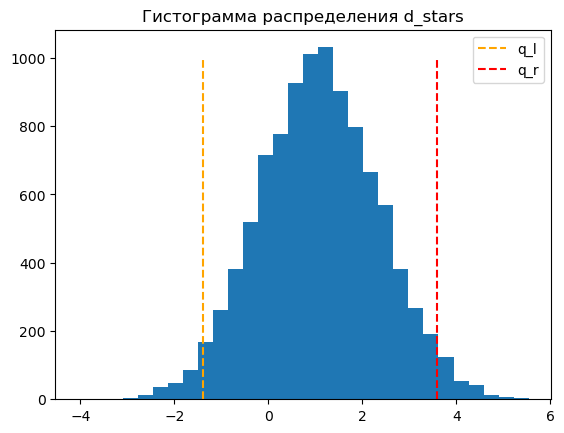

In [24]:
plt.hist(d_stars, bins=30)
plt.vlines(q_l, 0, 1000, linestyles='dashed', color='orange', label='q_l')
plt.vlines(q_r, 0, 1000, linestyles='dashed', color='red', label='q_r')

plt.title('Гистограмма распределения d_stars')
plt.legend();

__Вывод:__ Видим, что 0 попадает внутрь ДИ. Следовательно, гипотеза о равенстве ожидаемых результатов не отвергается, что согласуется с тем, что p-value больше уровня значимости.

__в)__ Используем бутстрэп $t$-статистики

In [25]:
C_base_sample = C['Score'].values
V_base_sample = V['Score'].values

In [26]:
n_C, n_V = len(C_base_sample), len(V_base_sample)

C_mean = np.mean(C_base_sample)
V_mean = np.mean(V_base_sample)

# Посчитаем несмещенные оценки дисперсии
S_C = np.var(C_base_sample, ddof=1)
S_V = np.var(V_base_sample, ddof=1)

In [27]:
# Создадим бутсрэп-выборки
np.random.seed(111)
C_bootstrapped = np.random.choice(C_base_sample, size=(10000, C_base_sample.shape[0]))
V_bootstrapped = np.random.choice(V_base_sample, size=(10000, V_base_sample.shape[0]))

In [28]:
def t_star(C_sample, V_sample):
    C_mean_star, V_mean_star = np.mean(C_sample), np.mean(V_sample)
    S_C_star, S_V_star = np.var(C_sample, ddof=1), np.var(V_sample, ddof=1)
    
    return (C_mean_star - V_mean_star - (C_mean - V_mean) ) / np.sqrt(S_C_star / n_C + S_V_star / n_V)

In [29]:
t_stars = [t_star(C_sample, V_sample) for C_sample, V_sample in zip(C_bootstrapped, V_bootstrapped)]

In [30]:
q_l_curr = np.quantile(t_stars, q= alpha / 2)
q_r_curr = np.quantile(t_stars, q=1 - alpha / 2)
print(q_l_curr, q_r_curr)

-2.1195208917383455 1.9667458361438348


In [31]:
# Посчитаем наблюдаемую t-статистику при верной H_0
t_obs = (C_mean - V_mean) / np.sqrt(S_C / n_C + S_V / n_V)
t_obs

0.8519661870595602

In [32]:
# Посчитаем p-value
p_value = 2 * min(np.mean(t_stars <= t_obs), np.mean(t_stars > t_obs))
p_value

0.4012

In [47]:
# Построим доверительный интервал
q_l = C_mean - V_mean - q_r_curr * np.sqrt(S_C / n_C + S_V / n_V)
q_r = C_mean - V_mean - q_l_curr * np.sqrt(S_C / n_C + S_V / n_V)
print(q_l, q_r)

-1.4108584573339886 3.760696276994703


__Вывод:__ Видим, что 0 принадлежит интервалу, следовательно, гипотеза о том, что ожидаемые результаты экзамена по теории вероятностей тех, у кого фамилия начинается с гласной буквы и с согласной буквы, равны, не отвергается.

__г)__ Используем перестановочный тест

In [44]:
C_base_sample = C['Score'].values
V_base_sample = V['Score'].values

n_C, n_V = len(C_base_sample), len(V_base_sample)

In [45]:
# Создадим выборки A и Y
A = np.hstack([np.zeros(len(V_base_sample)), np.ones(len(C_base_sample))])
Y = np.hstack([V_base_sample, C_base_sample])

In [46]:
def delta_star(A, Y, i):
    np.random.seed(i)
    A_star = np.random.permutation(A)
    cond = (A_star == 1)
    return Y[cond].sum() / n_C - Y[~cond].sum() / n_V

In [47]:
# Посчитаем delta_stars
delta_stars = [delta_star(A, Y, i) for i in range(10**4)]

In [48]:
# Посчитаем квантили
q_l = np.quantile(delta_stars, q=alpha / 2)
q_r = np.quantile(delta_stars, q=1 - alpha / 2)
print(q_l, q_r)

-2.345424388836806 2.418980312973247


In [52]:
# Посчитаем наблюдаемое значение разности
delta_hat = np.mean(C_base_sample) - np.mean(V_base_sample)
delta_obs

1.0782433114588574

In [53]:
# Посчитаем p-value
p_value = 2 * min(np.mean(delta_stars <= delta_hat), np.mean(delta_stars > delta_hat))
p_value

0.3728

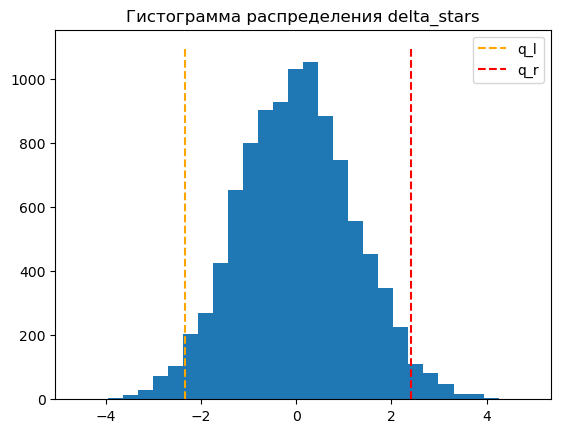

In [91]:
plt.hist(delta_stars, bins=30)

plt.vlines(q_l, 0, 1100, linestyles='dashed', color='orange', label='q_l')
plt.vlines(q_r, 0, 1100, linestyles='dashed', color='red', label='q_r')

plt.title('Гистограмма распределения delta_stars')
plt.legend();

__Вывод:__ Видим, что наблюдаемое значение попадает в интервал, следовательно, гипотеза о том, что ожидаемые результаты экзамена по теории вероятностей тех, у кого фамилия начинается с гласной буквы и с согласной буквы, равны, не отвергается.